In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import time

sns.set()

In [2]:
%matplotlib inline

In [3]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')

In [4]:
print(master.shape)
display(master.head())

(999950, 25)


,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
0,Sidney Bechet's Blue Note Jazzmen,spotify:artist:2XouUSO0EAJ9gMMoHiXqMt,Muskrat Ramble,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,220293,Jazz Classics,1,spotify:track:0002yNGLtYSYtc0X6ZnFvp,0.455,0.623,...,0.903,0.6340,0.951,182.345,4,[],18,[],37,1993-01-01
159583,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blue Horizon,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,264933,Jazz Classics,5,spotify:track:1EWPMNHfdVNJwBpG9BcxXB,0.327,0.372,...,0.835,0.1530,0.380,66.036,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
271702,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blame It On The Blues - Alternate Take,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,175893,Jazz Classics,1,spotify:track:26N4Y48EjprAtvlY6yWZTA,0.574,0.606,...,0.948,0.3490,0.965,101.361,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
445190,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Summertime,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,251906,Jazz Classics,16,spotify:track:3RlJx8xwZEyToSuGrygilr,0.608,0.138,...,0.908,0.0853,0.318,83.124,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
626275,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Dear Old Southland,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,243693,Jazz Classics,1,spotify:track:4qwAa1rOm8iaegHzoM1b31,0.400,0.320,...,0.842,0.1950,0.613,86.186,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01


There are some missing values here (throws an error if we try to fit a model). Drop rows with NA, as the remaining rows are those we intend to use.

In [5]:
old = master.shape
master.dropna(axis = 0, inplace = True)
print('Removed', old[0] - master.shape[0], 'observations')

Removed 9 observations


Convert `album_release_year` to a continuous number of the release year. The day of month or month itself of the release date is likely much less important. Should ideally treat as categorical, but this would give a *lot* of levels and not unreasonble to treat year as ordinal. 

In [6]:
master['album_release_year'] = np.array(
    [reldate[0:4] for reldate in master['album_release_date']], dtype = 'int')
master.drop(['album_release_date'], 1, inplace = True)

Several columns contain text (should be categorical):

In [7]:
master.dtypes

artist_name            object
artist_uri             object
track_name             object
album_uri              object
duration_ms             int64
album_name             object
count                   int64
track_uri              object
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature          int64
artist_genres          object
artist_popularity       int64
album_genres           object
album_popularity        int64
album_release_year      int64
dtype: object

Remove columns that we do not need:
- `album_genres` is always empty. Seems like a field that used to exist, but no longer does.
- `track_uri` is the url to the track. This is unique to each song and cannot be used to model. It is saved in the stored dataframe for reference if we need it later.
- `album_uri` for the same reason.
- `artist_uri` for the same reason.

Until we can effecrtively one-hot encode as categoricals, any remaining predictors of type `object` can be dropped, so that we only have numeric features.

In [8]:
master.drop(labels = ['album_genres', 'track_uri', 'album_uri', 'artist_uri'], 
           axis = 1, inplace = True)

Artist genres is missing for about $18\%$ of songs. For those that have it, it's a list of sometimes extremely specific genres. Hard to do something useful with, so drop it.

In [9]:
np.sum(master.artist_genres == '[]')/master.shape[0]

0.17600038402265733

We also can't do anything interest with track name (unless we want to try to use NLP to look for similarities in titles, but that seems like a stretch, so drop that too.

In [10]:
master.drop(['track_name', 'artist_genres'], 1, inplace = True)

Now whatever column is of type `object` is one we want to treat as categorical and one-hot-encode. Songs in the same album and/or by the same artist likely fit well together.  
  
**Note:** Perhaps redundant to keep both? If a song is in the same album, most of the time it will also be by the same artist? At the same time, collection albums may be a great way to indirectly capture genre information and relatedness beyond being by the same artist. There's just a *lot* of albums, i.e. we'll get a stupid amount of features with one-hot-encoding.

In [11]:
master.dtypes

artist_name            object
duration_ms             int64
album_name             object
count                   int64
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature          int64
artist_popularity       int64
album_popularity        int64
album_release_year      int64
dtype: object

# Fancy model alternatives

## Multiple Correspondence Analysis (MCA)
Not as a model, but as an alternative to PCA that works on categorical (binary) data, either for widened song-in-playlist indicators, or one-hot-encoded `artist` and/or `album` for songs.

Read more here: http://vxy10.github.io/2016/06/10/intro-MCA/  
Package here: https://pypi.org/project/mca/  
Why PCA isn't appropriate: https://www.reddit.com/r/MachineLearning/comments/3nuh7g/is_it_effective_to_use_one_hot_encoding_of/

Options:
1. ~~MCA to reduce dimensionality of song-in-playlist indicators (array takes too much memory and spares doesn't seem to work)~~: even with sparse and $n>100$ this runs OOM. See notebook `sparse matrix with MCA -- OOM error.ipynb` for the various attempts. 
2. MCA to reduce dimensionality of one-hot-encoded `artist` and/or `album` indicators

## Cosine Similarity and/or Euclidean Distance
Computes the angle $[0, 1]$ between two vectors, in our case between the vector of playlist indicators of two songs. A similarity of 1 means the songs appear in the exact same playlists.

Note that similarity is 1 - distance, and vice versa.

Can be done in chunks or subsets, but is still *very* computationally expensive due to the size of the vectors and sheer number of songs.

**Update:** Is now very fast using sparse `scipy` matrices and `sklearn` distance algorithms. Still runs OOM if try to do it pairwise across entire dataset, but not really any need for that: better to do one-vs-all (across entire dataset or across K-Means cluster) when populating playlists with seed songs. See details below.

## Multi-label models
From sklearn documentation: **Multiclass** classification algorithms require that each observation belongs to one – and only one, though potentially among many possible – class. **Multilabel**, in contrast, assigns to each sample a *set* of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A text might be about any of religion, politics, finance or education at the same time or none of these.

Read more here: https://scikit-learn.org/stable/modules/multiclass.html  
Multi-label models in `sklearn` on text data: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

1. Treat playlists as labels and assign each song multiple, according to which playlists it's in. Challenge: 200,000 classes, many with very few observations

## Song-in-playlist indicators as sparse matrix
https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#sparse-migration

In [12]:
# Read list of lists: parent index is playlist ID, child index is song in that playlist
playlists = pd.read_pickle('../data/playlists_song_ids_200.pkl')

# Give each parent list a number, i.e. playlist ID
play, song = zip(*enumerate(playlists))

# Expand into pairs of playlist-song, i.e. 100-long playlist becomes 100 pairs
pairs = [[z[0], s] for z in zip(play, song) for s in z[1]]

# column is song ID, row is playlist ID
col, row = zip(*pairs)
assert len(row) == len(col)

In [13]:
# Create sparse matrix
from scipy.sparse import csr_matrix, coo_matrix
mat = csr_matrix((np.ones(len(col), dtype = 'int'), (row, col)))
mat.shape

(1003760, 200000)

**Warning:** Usually `mat.A` gets you a dense matrix with zeros as zeros instead of simply being left out, *but* that will make Jupyter shit the bed due to the crazy memory requirements.

Various songs were ditched from the master songs table when adding metadata

In [14]:
mat = mat[master.index.values, :]
assert mat.shape[0] == master.shape[0]

Seems like it works: first playlist has 13 stored elements, corresponding to `len(playlists[0])`:

In [15]:
len(playlists[0]), mat[:, 0]

(13, <999941x1 sparse matrix of type '<class 'numpy.int64'>'
 	with 13 stored elements in Compressed Sparse Row format>)

#### Try Numpy operations on sparse matrix to see if we can do anything useful with it
**Works like a charm, and is *very* fast! :D**

In [16]:
# Occurrences of each song across all playlists
np.sum(mat, axis = 1)

matrix([[1],
        [5],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [17]:
# Songs in each playlist
np.sum(mat, axis = 0)

matrix([[ 13,  85, 156, ...,  48,   8,  25]], dtype=int64)

#### Drop songs that occur below a certain threshold $n$

In [18]:
n = 10

In [19]:
songs_keep_ind = np.argwhere(np.sum(mat, axis = 1) >= n)[:,0]

In [20]:
mat_sub = mat[songs_keep_ind, :]
mat_sub.shape

(123328, 200000)

In [21]:
# Sparsity original
1 - (np.sum(mat)/(mat.shape[0]*mat.shape[1]))

0.9999346299381664

In [22]:
# Sparsity new subset
1 - (np.sum(mat_sub)/(mat_sub.shape[0]*mat_sub.shape[1]))

0.9995422149876751

Drop the same songs from the master songs metadata table

In [23]:
master_sub = master.iloc[songs_keep_ind, :]
master_sub.shape

(123328, 19)

Some playlists now have no songs or are very short. Drop those containing less than $m$ songs:

In [24]:
m = 10

In [25]:
p_sums = np.array(np.sum(mat_sub, axis = 0)).reshape((-1,))

In [26]:
mat_sub = mat_sub[:, p_sums >= m]
mat_sub.shape

(123328, 183939)

**Warning:** Some songs may now never appear in any playlist (happens at least once), so be aware that summing across columns will yield some NaNs.

E.g. we have 

In [27]:
np.sum(mat_sub[0, :].A), mat_sub[0, :]

(12, <1x183939 sparse matrix of type '<class 'numpy.int64'>'
 	with 12 stored elements in Compressed Sparse Row format>)

In [28]:
from scipy.spatial.distance import cosine, euclidean, cdist

In [29]:
# Cosine here is DISTANCE, not similarity
1 - cosine(mat_sub[0, :].A, mat_sub[1, :].A)

0.0

In [30]:
1 - cosine(mat_sub[0, :].A, mat_sub[0, :].A)

1.0

Computing cosine similarity of even one song across the entire dataset is extremely slow. Probably best to do this from within the relevant cluster when pulling new songs to populate playlist (but need a lot of clusters for this to pay off, since time becomes original time divided by number of clusters).

#### ~~TODO: find a faster way to calculate this~~
#### DONE, see below

**Note:** The method is slow, but we'd technically only have to do this once per cluster (in total the entire dataset once) if we combine all seed songs into one vector.

In [31]:
similarities = [1 - cosine(mat_sub[0, :].A, mat_sub[i, :].A) for i in range(mat_sub.shape[0])]

//anaconda3/envs/ac209a/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [32]:
# Replace NaN with 0: occurs if a song never appears in any remaining playlist
similarities = np.nan_to_num(similarities, nan = 0)

In [33]:
assert len(similarities) == mat_sub.shape[0]

Song ID of first song (for which we want to find closest neighbours):

In [64]:
master_sub.index.values[0]

445190

#### TODO: find a good way combine all seed songs into one vector and calculate cosine similarity against all songs in cluster from which we pull new songs for efficiency, preferably weighting shared playlists across the seed songs more heavily (if multiple seed songs are in a playlist, that's likely a good playlist to pull new songs from)
Way to weight more important songs: e.g. if $n$ songs appear in the most frequent playlist, weight that by $1$ and all playlists with only one seed song by $1/n$ when calculating distance. Hence, a song that appears in the most frequent playlist gets a distance of $0$ for that playlist, $1$ for playlists that aren't a match, and $1-1/n$ for playlists with only one seed song.

In [60]:
# Find the ten songs most similar to the first song in master (including self)
similarities[np.argsort(similarities)[::-1][0:10]]

array([1.        , 0.2236068 , 0.20412415, 0.19867985, 0.19364917,
       0.19245009, 0.18257419, 0.16012815, 0.15430335, 0.1490712 ])

In [62]:
# Song IDs of the closest songs
master_sub.index.values[np.argsort(similarities)[::-1][0:10]]

array([445190, 421694, 883140, 135113, 800583, 657505, 717728, 644240,
       820522, 842045])

#### ~~TODO: Maybe Euclidian distance is faster and/or makes more sense?  ~~~
#### Not faster, boils down to judgment call which makes more sense. See below.
That's what the paper use in their probabilistic embedding of playlists

In [41]:
euc_dist = [euclidean(mat_sub[0, :].A, mat_sub[i, :].A) for i in range(mat_sub.shape[0])]

In [65]:
# Euclidean distances of 10 closest songs in indicator vector space
np.array(euc_dist)[np.argsort(euc_dist)][0:10]

array([0.        , 3.46410162, 3.60555128, 3.60555128, 3.60555128,
       3.74165739, 3.74165739, 3.74165739, 3.74165739, 3.87298335])

In [66]:
master_sub.index.values[np.argsort(euc_dist)[0:10]]

array([445190, 348315, 231929, 613065, 355371, 538055, 202803, 513149,
       242376,   1975])

Cosine similarity and Euclidean distance give different results. Which is better?

### This is super-efficient! Runs in virtually an instant
**Note:** it is not the most precise way of doing the computation, trading off precision for speed, but it is so very nearly identical as to be negligibly imprecise.

**Note:** Still shits the bed if try to do it for the entire dataset. Need to do one or a few vs all.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html

In [68]:
from sklearn.metrics.pairwise import euclidean_distances

In [85]:
euc_dist_sklearn = euclidean_distances(mat_sub, mat_sub[0, :])

In [86]:
euc_dist_sklearn = euc_dist_sklearn.reshape((-1,))

In [93]:
print('Exactly equal to scipy in % of cases:', 
      100*np.sum(euc_dist == euc_dist_sklearn)/len(euc_dist))

Exactly equal to scipy in % of cases: 98.73345874416191


In [99]:
# Sorted closest songs by distance
euc_dist_sklearn[np.argsort(euc_dist_sklearn)][0:10]

array([0.        , 3.46410162, 3.60555128, 3.60555128, 3.60555128,
       3.74165739, 3.74165739, 3.74165739, 3.74165739, 3.87298335])

In [100]:
# Sorted closet songs by ID
master_sub.index.values[np.argsort(euc_dist_sklearn)[0:10]]

array([445190, 348315, 231929, 613065, 355371, 538055, 202803, 513149,
       242376,   1975])

#### Try same speed-up for cosine distance / similarity
Also very fast
  
*"Cosine distance is defined as 1.0 minus the cosine similarity."*  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances

In [102]:
from sklearn.metrics.pairwise import cosine_distances

In [103]:
cos_dist_sklearn = cosine_distances(mat_sub, mat_sub[0, :])

In [106]:
cos_dist_sklearn = cos_dist_sklearn.reshape((-1,))

In [109]:
# Sorted closest songs by cosine distance
cos_dist_sklearn[np.argsort(cos_dist_sklearn)][0:10]

array([0.        , 0.7763932 , 0.79587585, 0.80132015, 0.80635083,
       0.80754991, 0.81742581, 0.83987185, 0.84569665, 0.8509288 ])

In [110]:
# Sorted closest songs by cosine distance
master_sub.index.values[np.argsort(cos_dist_sklearn)[0:10]]

array([445190, 421694, 883140, 135113, 800583, 657505, 717728, 644240,
       820522, 842045])

# TODO: MCA one-hot-encoded artist and album names

In [40]:
master_sub.dtypes

artist_name            object
duration_ms             int64
album_name             object
count                   int64
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature          int64
artist_popularity       int64
album_popularity        int64
album_release_year      int64
dtype: object

# Original baseline work below
## For easy copying, nothing new done

In [6]:
master.drop(labels = list(master.columns[np.where(master.dtypes == np.dtype('O'))]), 
            axis = 1, inplace = True)

In [7]:
master.dtypes

duration_ms            int64
count                  int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature         int64
artist_popularity      int64
album_popularity       int64
dtype: object

No point in running cross-validation here since we have unlabelled data. Hence, simple train test split not for the purpose of evaluating out-of-sample (since we have no labels), but so we can subjectively evaluate how our unsupervised methods and/or algorithms for playlist generation perform on unseen data (as unsupervised still does fit to the data it sees). Since we have a million songs and have to evaluate out-of-sample manually, a specific number of, say, $500$ songs held out is plenty.

In [9]:
test_size = 500

np.random.seed(42)

test_songids = np.random.choice(master.index, test_size, replace = False)
train_songids = list(set(master.index) - set(test_songids))

# Verify that it works
assert set(np.append(train_songids, test_songids)) == set(master.index)

# Split up into train and test
train_df = master.loc[train_songids, :]
test_df = master.loc[test_songids, :]

print(train_df.shape, len(train_songids))
print(test_df.shape, len(test_songids))

(999449, 16) 999449
(500, 16) 500


## Min-Max scaling
Before we can pass the data through distance-based algorithm, we need to scale the data.

In [11]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

train = minmax.fit_transform(np.array(train_df))
test = minmax.transform(np.array(test_df))

# K-Means Clustering
The number of clusters here maps directly to the number of families of playlists we can generate. Every song will be predicted to belong to a cluster, and the rest of the playlist generated with songs from that cluster.  
  
Read about K-Means:
- https://stats.stackexchange.com/questions/78313/clustering-inertia-formula-in-scikit-learn
- https://pythonprogramminglanguage.com/How-is-the-k-nearest-neighbor-algorithm-different-from-k-means-clustering/
- https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, random_state = 42, max_iter = 300, verbose = 0)

kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [13]:
# Verify that model did in fact converge
assert kmeans.n_iter_ < 300

# Verify we got a prediction for every observation in train
assert len(kmeans.labels_) == train.shape[0]

# Sum of squared distances of samples (train) to their closest cluster center
# kmeans.inertia_

# Centers of the clusters in the n-dimensions (n features we have)
cluster_centers = kmeans.cluster_centers_

train_labels = kmeans.labels_

train_labels

array([4, 3, 9, ..., 4, 8, 2], dtype=int32)

In [14]:
# Predict cluster of a new song
kmeans.predict(test[0:1])

array([0], dtype=int32)

In [15]:
# Get distance of each observation (row) to each cluster center (dimension/col)
assert np.argmin(kmeans.transform(test)[0, :]) == kmeans.predict(test[0:1,:])[0]

kmeans.transform(test)

array([[0.5717778 , 1.53016475, 0.91827857, ..., 1.13711186, 1.37275648,
        1.45940979],
       [1.28728561, 1.88519576, 1.63465316, ..., 1.65956538, 1.95992825,
        1.71398014],
       [1.05172421, 1.32522789, 0.72737447, ..., 1.47060346, 1.28736791,
        1.71022089],
       ...,
       [1.20090681, 1.13637126, 1.43334371, ..., 0.55016178, 1.0032258 ,
        0.95137579],
       [1.39083634, 1.2037908 , 1.2761475 , ..., 1.76238399, 1.69562774,
        1.44072719],
       [0.93981051, 1.2555465 , 0.64140653, ..., 1.35730384, 1.20760668,
        1.56728068]])

In [16]:
# Sizes of fit clusters (num songs in each)
clust, count = np.unique(train_labels, return_counts = True)
for cl, co in zip(clust, count):
    print(cl, ':', co)

0 : 66979
1 : 55468
2 : 203413
3 : 175581
4 : 63468
5 : 146077
6 : 102463
7 : 48909
8 : 103245
9 : 33846


## Use K-Means to generate playlist from cold start

Given a set of start songs for the cold start, there are some potential ways of populating a playlist. For each of those songs, predict the cluster to which it belongs, then either:
- Pull songs from the mode cluster (i.e. the most common), if tied pick a random cluster and get all new songs from there.
- **Our implementation**: Pull randomly from one of the predicted clusters each time, with probability weighted equal to the number of times each cluster was predicted.
- Instead of predicting the single cluster of each start song, get its distance to all clusters, sum them up, average them, and use that to determine the closet cluster(s) of the songs as a group, then pull from either the closest one or closest $n$ with some weighting scheme (e.g. by distance).

Should handle running out of songs to sample from, i.e. if we exhaust the cluster when pulling new songs to populate the playlist, but with a reasonably low number of clusters there are so many it seems very unlikely any playlist will be so long it exhausts any cluster.

Algorithm to use a KMeans clustering model to generate a playlist. Given a fit KMeans and a set of seed songs with which to start the playlist, the algorithm predicts the cluster of each seed song using the model. It then generates a sequence of the cluster from which it will pull each new song in the playlist, weighting the probability of each cluster by the number of seed songs that belongs to that cluster. Iterating through that sequence, it pulls a random song from the respective cluster, removing it from the next iteration to avoid duplicate songs in the new playlist (however unlikely, with the dataset size). Finally, it returns the new songs in the playlist in terms of their indices in the test set and their song id in the master songs table.

In [21]:
'''
Function to generate a new playlist based on a given set of starting songs
Returns the list new songs, both as their indices in the train set and as song ids in master
Note: returns are exclusive of seed songs, so need to prepend those first if to be included
'''
def generate_playlist(start_songs, playlist_length = 20):
    # Ensure proper dimensions of songs: handles list of individual songs or set of songs
    start_clusters = kmeans.predict(np.reshape(start_songs, (len(start_songs), -1)))
    print('Starting songs clusters:', start_clusters)

    # Get count of each start cluster and its respective weight of total
    start_cluster, cluster_count = np.unique(start_clusters, return_counts = True)
    start_cluster, cluster_count = list(start_cluster), list(cluster_count)
    cluster_weight = cluster_count / np.sum(cluster_count)
    print('Cluster, Counts, Weights:', start_cluster, cluster_count, cluster_weight)

    # For each cluster from which we will sample, get indices of all songs in train set
    cluster_song_ind = [np.argwhere(train_labels == c).reshape((-1,)) for c in start_cluster]
    # Flatten component arrays
    print(len(cluster_song_ind), 'clusters with # songs each:', [len(clust) for clust in cluster_song_ind])

    # Sample list of clusters with which to populate playlist
    new_song_clusters = np.random.choice(start_cluster, size = playlist_length, p = cluster_weight)
    print('\nNew song clusters:', new_song_clusters)
    
    new_song_train_inds = np.empty((playlist_length), 'int')
    new_song_ids = np.empty((playlist_length), 'int')

    # For each new song
    print('\nRandom song from each random cluster in order:\ncluster train_ind cluster_size')
    for i, ns_c in enumerate(new_song_clusters):
        # Get index of new song cluster from list of train set song indices of each cluster to use
        ns_c_ind = start_cluster.index(ns_c)

        # Get training set index of a random new song from current cluster
        ns_train_ind = np.random.choice(cluster_song_ind[ns_c_ind], size = 1)[0]
        # Remove this song from the temporary list of cluster songs to avoid repeating songs
        cluster_song_ind[ns_c_ind] = cluster_song_ind[ns_c_ind][cluster_song_ind[ns_c_ind] != ns_train_ind]

        # Add song train set index to list of songs in new playlist
        new_song_train_inds[i] = ns_train_ind

        # Get actual song id from master songs table and add to list of new songs
        new_song_ids[i] = train_songids[ns_train_ind]

        # Print cluster of new song, its index in train, and new length of cluster
        print(ns_c, ns_train_ind, len(cluster_song_ind[ns_c_ind]))

    print('\nNew song train indices:\n', new_song_train_inds)
    print('\nNew song IDs from master table:\n', new_song_ids)
    
    return new_song_train_inds, new_song_ids


Run the function to showase how the baseline model for playlist generation works, and show the example generated playlist based on a set of previously unseen seed/starter songs.

In [22]:
# Number of songs with which to seed
songs_seed = 3

# Showcase different ways of passing in songs (list of arrays/vectors, whole array)
#start_songs = [test[i:i+1, :] for i in range(songs_seed)]
start_songs = test[0:songs_seed, :]

# Run function to generate playlist
playlist_train_indices, playlist_song_ids = generate_playlist(start_songs, 20)

Starting songs clusters: [0 0 3]
Cluster, Counts, Weights: [0, 3] [2, 1] [0.66666667 0.33333333]
2 clusters with # songs each: [66979, 175581]

New song clusters: [3 0 3 3 0 0 3 3 3 3 3 3 0 0 0 0 0 3 3 3]

Random song from each random cluster in order:
cluster train_ind cluster_size
3 778403 175580
0 373778 66978
3 913673 175579
3 628419 175578
0 353901 66977
0 100063 66976
3 384855 175577
3 323133 175576
3 387588 175575
3 306768 175574
3 183521 175573
3 31459 175572
0 75990 66975
0 890223 66974
0 221048 66973
0 614152 66972
0 698068 66971
3 720405 175571
3 607844 175570
3 552151 175569

New song train indices:
 [778403 373778 913673 628419 353901 100063 384855 323133 387588 306768
 183521  31459  75990 890223 221048 614152 698068 720405 607844 552151]

New song IDs from master table:
 [781791 375439 917610 631163 355467 100504 386561 324567 389300 308130
 184357  31600  76318 894070 222045 616840 701111 723540 610510 554565]


Show generated playlist as list of songs with metadata. Our seed/starter songs appear first, then the rest in the sequence in which they were generated.  
  
*Note: the K-Means and algorithm only use numeric values, so the non-numeric data below can be misleading as it was not taken into account.*

In [23]:
# Playlist as list of songs with metadata
pd.read_pickle('../data/master200.pkl').loc[np.append(test_songids[0:3], playlist_song_ids)]

,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
554407,Mint Condition,spotify:artist:4MT97VeycuegSicrrphisJ,Definition Of A Band,spotify:album:7a19lFps8uDiFZr1bhJmmY,59866,Definition Of A Band,1,spotify:track:4IAWtxmJ13hXTlxwuG77M0,0.434,0.578,...,0.821000,0.0713,0.66200,97.430,3,"['dance pop', 'funk', 'hip pop', 'minneapolis ...",54,[],44,1996-01-01
774639,"Nature Sounds Relaxation: Music for Sleep, Med...",spotify:artist:1qzR1EqCmsTDa9AwBLTT4b,"Nature Sounds – Waterfall, Trickling Cascades ...",spotify:album:57nnU1noZOVKKR7yzonkWD,228893,Nature Sounds,1,spotify:track:60QW1IideSuHPbuoz7dfZh,0.096,1.000,...,0.918000,0.9770,0.00001,160.678,1,"['environmental', 'sleep']",34,[],32,2011-11-01
239936,Brainstorm,spotify:artist:6JPBUFrfF5w5whOPk2w0kp,You Put A Charge In My Life,spotify:album:4tLBJzaV71qm3TyepiEIBy,251733,Funky Entertainment,3,spotify:track:1r69KR1iUoLfoN4Z44Okca,0.590,0.527,...,0.000000,0.7550,0.73100,144.911,4,['p funk'],35,[],35,1979
781791,One-Eyed Doll,spotify:artist:4w2wxHsHxLp64aXeZ9v1nW,Nudie Bar,spotify:album:6rxmXoRR5WWmSKQe3682A2,173026,Hole,1,spotify:track:63tL5Gza0dbe3zBNIniuOL,0.523,0.930,...,0.006690,0.3310,0.83700,160.161,4,"['hard glam', 'steampunk', 'texas punk']",31,[],19,2007-02-20
375439,El Huervo,spotify:artist:2gG1LfmQPkHZNptgVpYlpr,Rust,spotify:album:10sWEyUUMMS1i26Iaw94lk,297473,Rust B/W Ghost,6,spotify:track:2uA9EGy7KifPvk2F342IvR,0.745,0.762,...,0.862000,0.1390,0.31100,92.493,4,[],45,[],38,2015-10-05
917610,Cathedral,spotify:artist:5O7ziOtiFUyRMBJN1J4Tpv,Hopkins (Witchfinder General),spotify:album:1Sks1BI0egVhaE9zni8ddf,318280,The Serpent's Gold,1,spotify:track:77cgeHw3mJPfKjivt1HRk1,0.312,0.969,...,0.008850,0.2900,0.22700,137.177,4,"['death metal', 'doom metal', 'metal', 'sludge...",33,[],18,2004
631163,We As Human,spotify:artist:6FFTGpuvFDztqTz4t1Hqy9,We Fall Apart,spotify:album:79dn7GARLrAgKx28cwvLea,230786,We As Human,46,spotify:track:4tMOesd7zi9cLH7KZh0DcP,0.482,0.544,...,0.000000,0.1310,0.40400,119.957,4,"['christian alternative rock', 'christian hard...",44,[],47,2011-06-21
355467,Jaws Underground,spotify:artist:0cqwBctx3ja0npObrVSfoU,The Rules,spotify:album:52lCoLmoM1AqGgsYBA94wi,531200,Still Alive,1,spotify:track:2kVexGVnckELYvAxVau9lo,0.530,0.992,...,0.832000,0.3400,0.12500,150.018,4,['deep full on'],8,[],3,2010-12-16
100504,Cascandy,spotify:artist:2jSv6vhlLlg9Urqffm5DwO,Four - Flip,spotify:album:3emOirW73LwC74J6jkVmfr,464640,Collection One Compilation,1,spotify:track:0mDfDoK5GBLJ5xQW7zv14f,0.869,0.614,...,0.779000,0.1150,0.25600,125.204,4,[],24,[],0,2011-05-02


## t-SNE of K-Means clusters on scaled data
#### T-Distributed Stochastic Neighbouring Entities
To visualise song clustering from K-Means in a t-sne embedded space

In [86]:
from sklearn.manifold import TSNE

In [87]:
# Data already shuffled, so we can pull a random subset of train data for visualisation
np.random.seed(42)
tsne_ind = np.random.choice(np.arange(train.shape[0]), 10000)

train_subset = train[tsne_ind, :]
train_subset_clusters = train_labels[tsne_ind]

Code heavily borrowed from:  
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [88]:
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(train_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 1.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.197524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.479248
[t-SNE] KL divergence after 300 iterations: 2.924045
t-SNE done! Time elapsed:

In [89]:
train_subset = np.concatenate((train_subset, tsne_results), axis = 1)

<IPython.core.display.Javascript object>


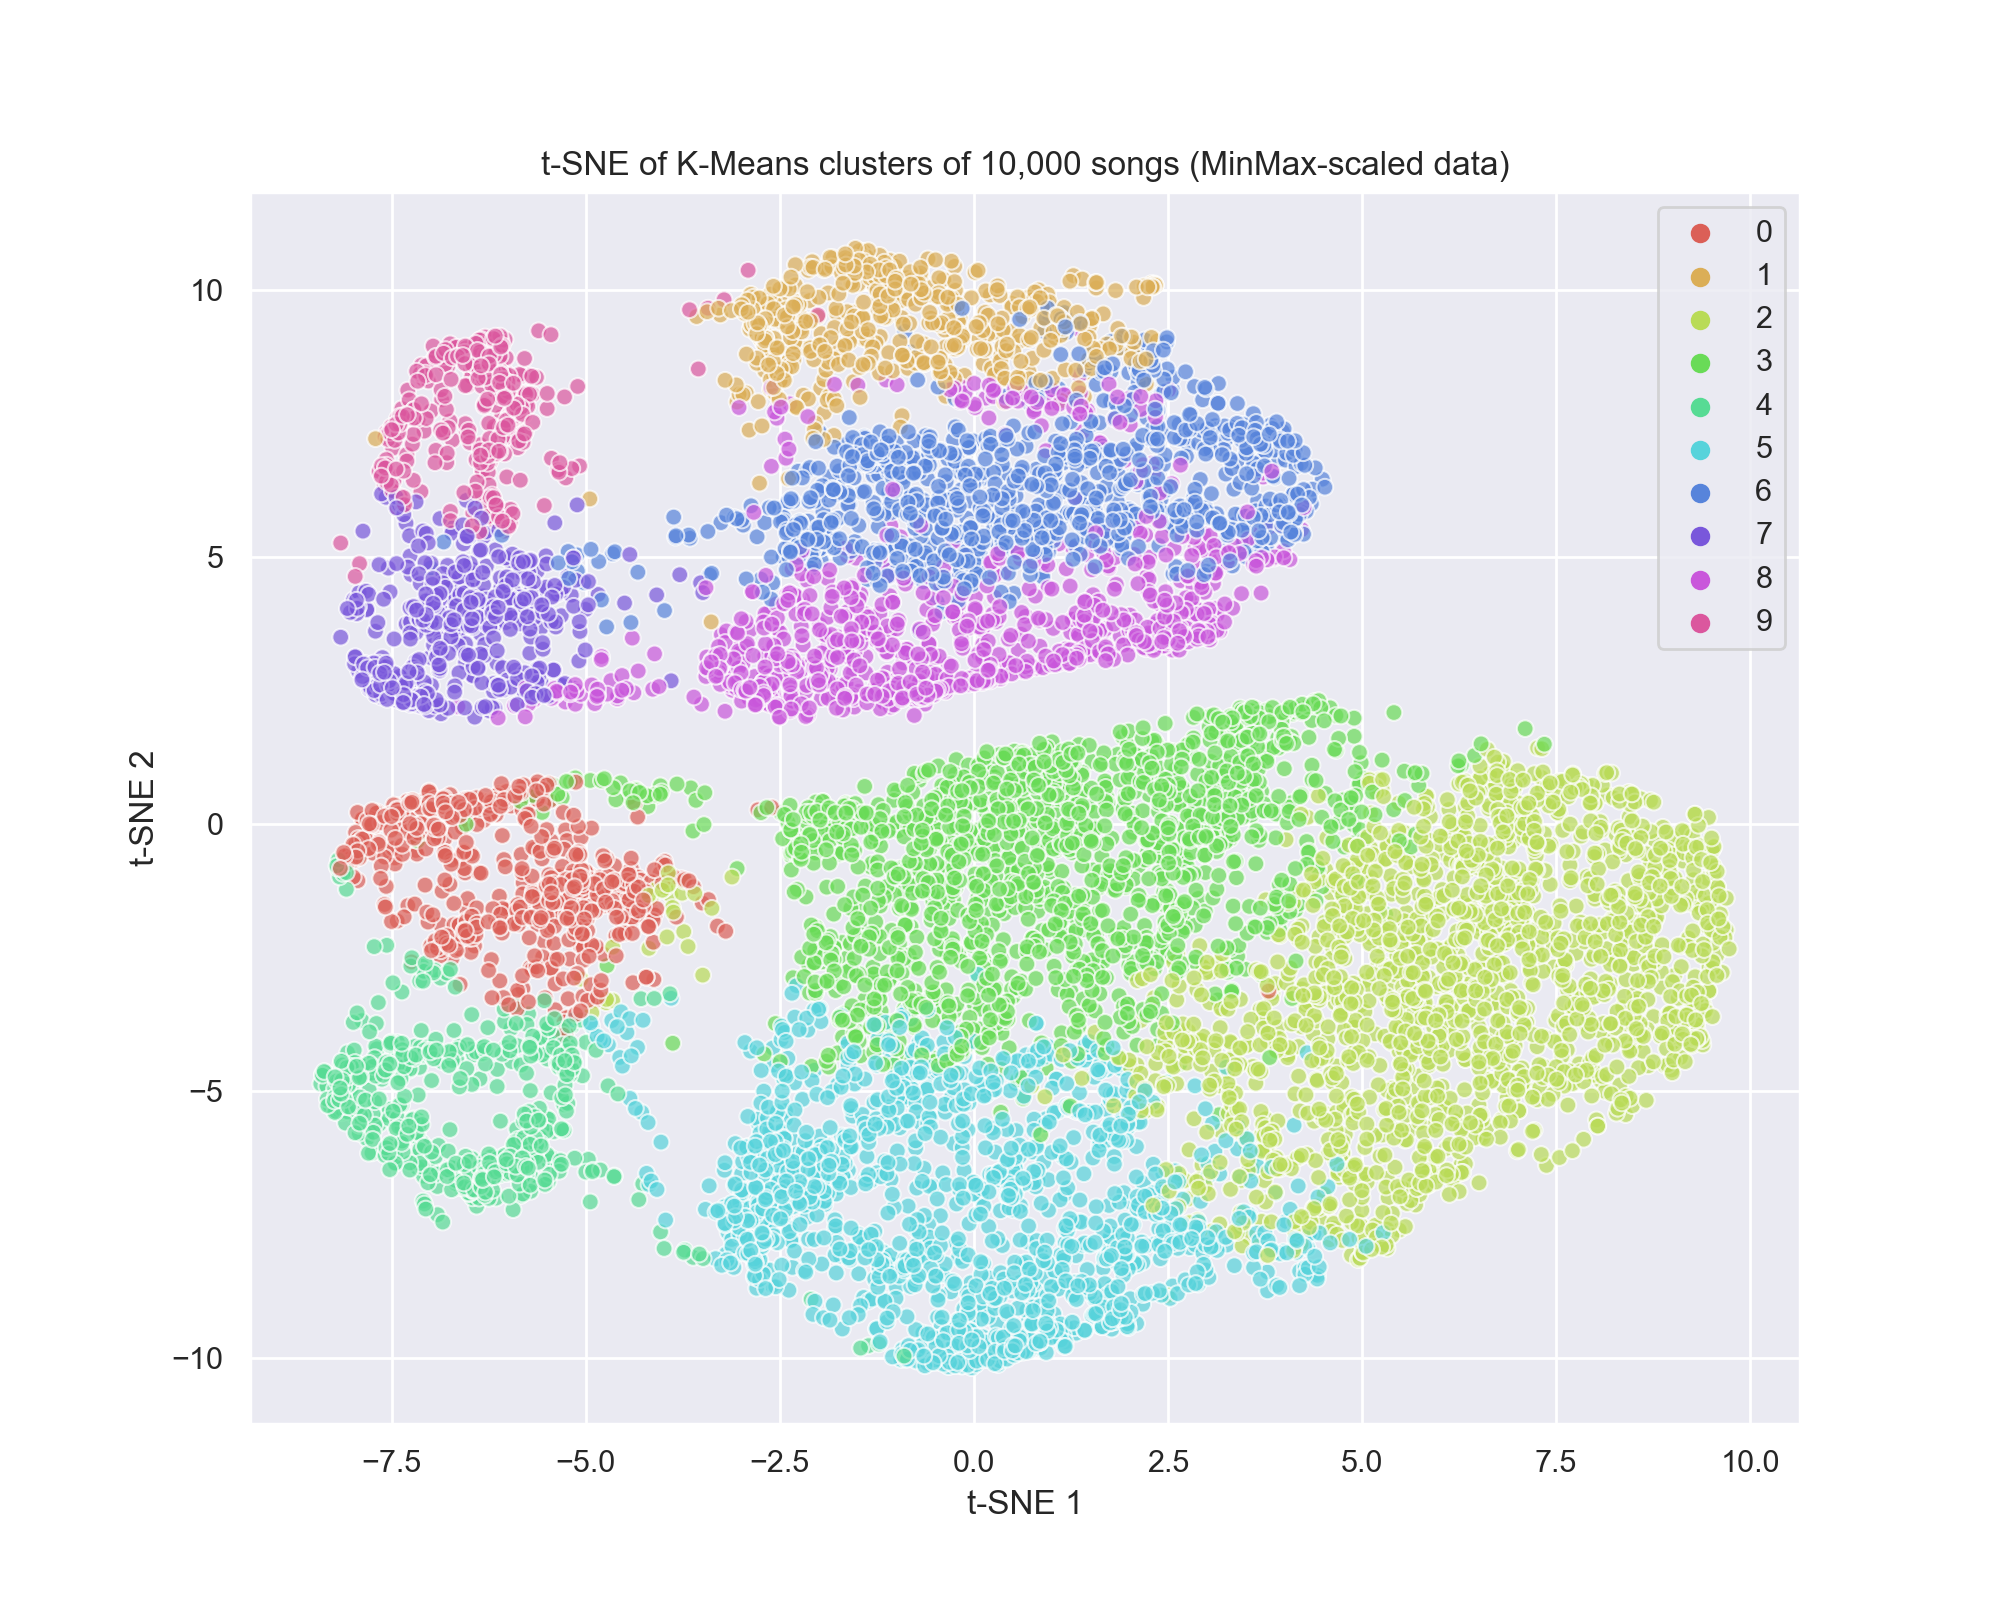

In [95]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = train_subset[:, -2], 
    y = train_subset[:, -1],
    hue = train_subset_clusters,
    palette = sns.color_palette("hls", 10),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')